In [171]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.externals.six import StringIO 
import graphviz
from IPython.display import Image
import pydotplus

pd.set_option('display.max_columns', None)
%matplotlib inline

In [172]:
df3 = pd.read_csv('data/preprocessed_data.csv')
df3 = df3.drop(df3.columns[0], axis=1)
df3.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted,service_utilization,num_diabetes_meds,change|num_medications,time_in_hospital|num_medications,num_medications|num_procedures,num_lab_procedures|time_in_hospital,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,number_diagnoses|time_in_hospital,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_1,admission_type_3,admission_type_4,admission_type_5,disch_dispo_1,disch_dispo_2,disch_dispo_7,disch_dispo_10,disch_dispo_18,disch_dispo_27,disch_dispo_28,admission_source_1,admission_source_2,admission_source_3,admission_source_4,admission_source_5,admission_source_6,admission_source_7,admission_source_8,admission_source_9,admission_source_10,admission_source_11,admission_source_13,admission_source_14,admission_source_17,admission_source_20,admission_source_22,admission_source_25,level1_diag_0.0,level1_diag_1.0,level1_diag_2.0,level1_diag_3.0,level1_diag_4.0,level1_diag_5.0,level1_diag_6.0,level1_diag_7.0,level1_diag_8.0,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1C_>7,A1C_>8,A1C_None,A1C_Norm
0,0,5,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,41,1,5,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,0,15,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,18,54,0,177,1062,162,135,27,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,25,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,26,65,22,143,78,150,12,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,35,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,16,32,16,88,704,112,245,14,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,45,1,51,0,8,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,8,8,0,51,408,40,225,5,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [173]:
# generate feature set and identify target variable
X = df3.loc[:, df3.columns != 'readmitted']
y = df3['readmitted']

#### Logistic Regression

In [174]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # using L1 as the penalty term - Lasso Regression will shrink less important features
# # Lasso is useful in this scenario becuase we have lot of features in our model

# logreg = LogisticRegression(penalty='l1')
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

In [175]:
# print("Cross Validation Score: ", cross_val_score(logreg, X_train, y_train, cv=10))
# print("Accuracy: ", accuracy_score(y_test, y_pred))

In [176]:
# print("Confusion Matrix:")
# pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

In [177]:
# print(classification_report(y_test, y_pred))

In [178]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# auc_score = roc_auc_score(y_test, y_pred)

# print("Accuracy: ", accuracy)
# print("Precision: ", precision)
# print("Recall: ", recall)
# print("AUC: ", auc_score)

In [179]:
# fpr, tpr, threshold = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [180]:
# print('Original dataset shape {}'.format(Counter(y)))
# smt = SMOTE(random_state=42)
# X_new, y_new = smt.fit_sample(X, y)
# print('New dataset shape {}'.format(Counter(y_new)))

In [181]:
# X_new = pd.DataFrame(X_new, columns=X.columns)
# X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# logreg = LogisticRegression(penalty='l1')
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

In [182]:
# print("Cross Validation Score: ", cross_val_score(logreg, X_train, y_train, cv=10))
# print("Accuracy: ", accuracy_score(y_test, y_pred))

In [183]:
# print("Confusion Matrix:")
# pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

In [184]:
# print(classification_report(y_test, y_pred))

In [185]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# auc_score = roc_auc_score(y_test, y_pred)

# print("Accuracy: ", accuracy)
# print("Precision: ", precision)
# print("Recall: ", recall)
# print("AUC: ", auc_score)

In [186]:
# fpr, tpr, threshold = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

#### Decision Tree Classification

In [187]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64139, 1: 6296})
New dataset shape Counter({0: 64139, 1: 64139})


In [188]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=25, criterion = 'entropy', min_samples_split=10)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [189]:
print("Cross Validation Score: ", cross_val_score(dtree, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.90457633 0.90168133 0.90544604 0.90232765 0.90344136 0.91179419
 0.90433233 0.90299588 0.90655975 0.90978951]
Accuracy:  0.9070003118178983


In [190]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,17618,1779,19397
1,1800,17287,19087
All,19418,19066,38484


In [191]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     19397
           1       0.91      0.91      0.91     19087

   micro avg       0.91      0.91      0.91     38484
   macro avg       0.91      0.91      0.91     38484
weighted avg       0.91      0.91      0.91     38484



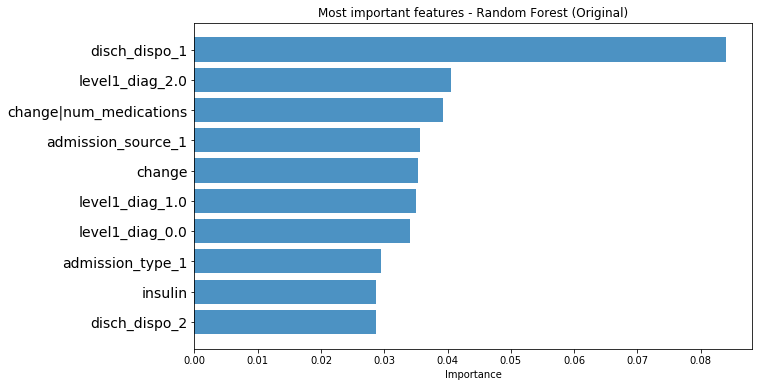

In [192]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (Original)')
plt.show()

In [193]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9070003118178983
Precision:  0.9066925416972621
Recall:  0.9056949756378687
AUC:  0.9069898809725149


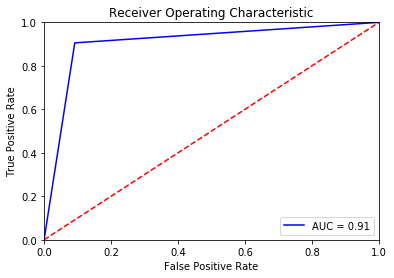

In [194]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [195]:
# dot_dt_q2 = tree.export_graphviz(dtree, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2, 
#                                  class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
# graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
# Image(graph_dt_q2.create_png())

In [196]:
# dot_data = StringIO()
# export_graphviz(dtree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

#### Random Forest Classification

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [198]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.91058394 0.91097141 0.9111742  0.91095335 0.90953347 0.91014199
 0.91196755 0.91054767 0.91014199 0.91135903]
Accuracy:  0.9093275282759926


In [199]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,5680,4,5684
1,604,1,605
All,6284,5,6289


In [200]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19226
           1       0.24      0.00      0.01      1905

   micro avg       0.91      0.91      0.91     21131
   macro avg       0.57      0.50      0.48     21131
weighted avg       0.85      0.91      0.87     21131



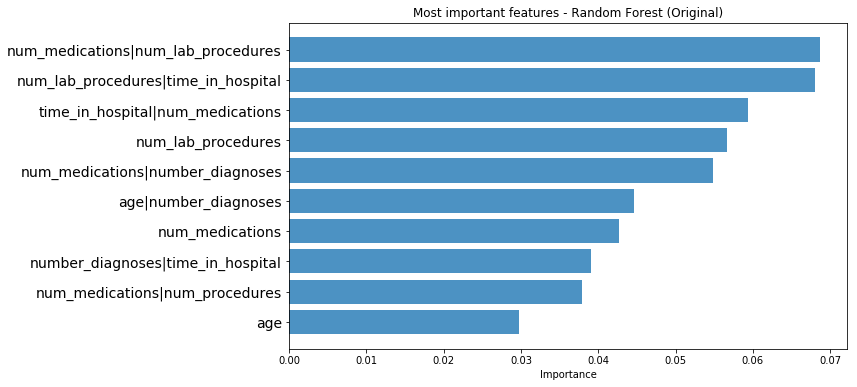

In [201]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (Original)')
plt.show()

In [202]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9093275282759926
Precision:  0.23809523809523808
Recall:  0.0026246719160104987
AUC:  0.5008962327644133


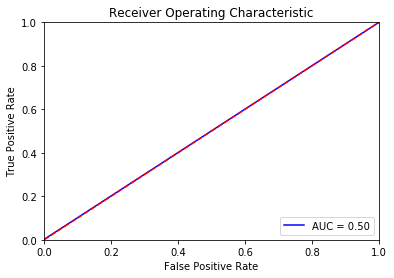

In [203]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [204]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64139, 1: 6296})
New dataset shape Counter({0: 64139, 1: 64139})


In [205]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [206]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.94065249 0.9404298  0.93651854 0.93128411 0.93919145 0.9439804
 0.93729814 0.93718677 0.94063927 0.94019379]
Accuracy:  0.9427294460035339


In [207]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,19207,190,19397
1,2014,17073,19087
All,21221,17263,38484


In [208]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     19397
           1       0.99      0.89      0.94     19087

   micro avg       0.94      0.94      0.94     38484
   macro avg       0.95      0.94      0.94     38484
weighted avg       0.95      0.94      0.94     38484



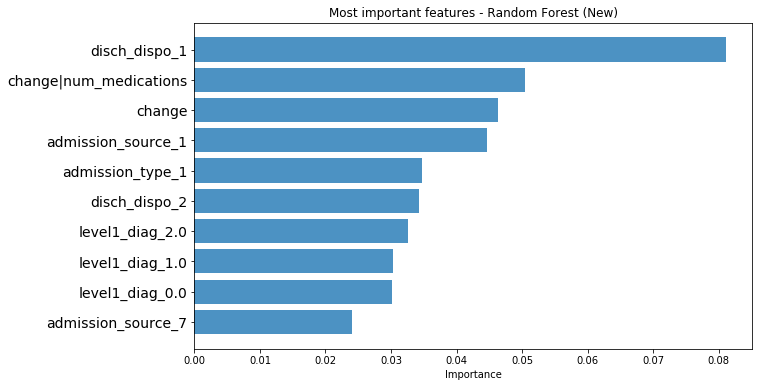

In [209]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (New)')
plt.show()

In [210]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9427294460035339
Precision:  0.9889938017725772
Recall:  0.8944831560748153
AUC:  0.9423439134501004


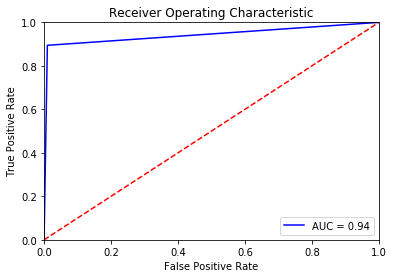

In [211]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()